In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import io

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [26]:
from utils import *
from data import *
from models import *
from train import *

In [27]:
%run data.py
%run utils.py
%run models.py
%run train.py

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Import

In [5]:
data_1lead = import_afc_data()

labelmap = {x:i for i,x in enumerate(list(set([x[1] for x in data_1lead])))}

dataset_1lead = WindowDataset(data_1lead, labelmap, device=device)

100%|██████████| 8528/8528 [00:00<00:00, 21431.45it/s]
8528it [00:01, 6442.60it/s]


In [6]:
data_12lead = import_balanced_12lead_data()

dataset_12lead = WindowDataset(data_12lead, labelmap, device=device, trim_samples=1000)

3318it [00:03, 967.96it/s] 


In [7]:
pd.Series([x[1] for x in data_1lead]).value_counts()

N    5076
O    2415
A     758
~     279
Name: count, dtype: int64

In [8]:
pd.Series([x[1] for x in data_12lead]).value_counts()

A    1106
N    1106
O    1106
Name: count, dtype: int64

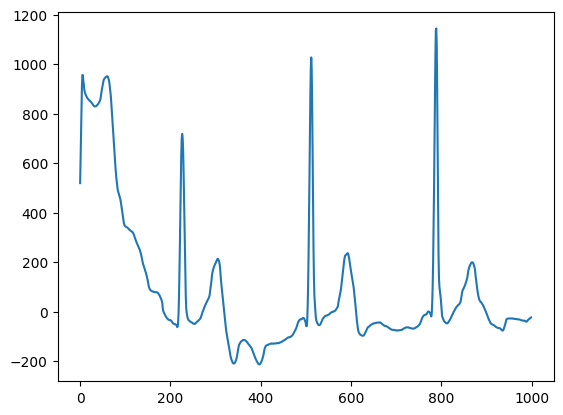

In [9]:
def plotwave(x, n=1000):
    plt.plot(x[:n])

plotwave(data_1lead[3][0])

In [10]:
value_counts = dataset_1lead.get_value_counts()
weights = [sum(value_counts)/x for x in value_counts]
weights[labelmap['~']] = weights[labelmap['N']]

# Training

In [11]:
## Train k-fold crossvalidated model on 1 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap

# history = train_kfold_model(dataset_1lead, trainparams, test=)

# plot_tt_graph(history, idx=0)
# display_results(history,trainparams=trainparams)

In [12]:
## Build model on entire 1lead dataset and save to buffer

buffer = io.BytesIO()

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs = 200

model, history = train_entire_model(dataset_1lead, trainparams)

torch.save(model.state_dict(), buffer)

Epoch:10/200 AVG Training Loss:0.02455 AVG Test Loss:0.02328 AVG Training Acc 55.77 % AVG Test Acc 55.12 %
Epoch:20/200 AVG Training Loss:0.02269 AVG Test Loss:0.02169 AVG Training Acc 60.65 % AVG Test Acc 62.75 %
Epoch:30/200 AVG Training Loss:0.02220 AVG Test Loss:0.02081 AVG Training Acc 61.22 % AVG Test Acc 65.98 %
Epoch:40/200 AVG Training Loss:0.02124 AVG Test Loss:0.02104 AVG Training Acc 63.85 % AVG Test Acc 67.85 %
Epoch:50/200 AVG Training Loss:0.02086 AVG Test Loss:0.02142 AVG Training Acc 65.00 % AVG Test Acc 68.09 %
Epoch:60/200 AVG Training Loss:0.02032 AVG Test Loss:0.01922 AVG Training Acc 65.24 % AVG Test Acc 69.95 %
Epoch:70/200 AVG Training Loss:0.02012 AVG Test Loss:0.01845 AVG Training Acc 66.52 % AVG Test Acc 68.07 %
Epoch:80/200 AVG Training Loss:0.01989 AVG Test Loss:0.01874 AVG Training Acc 66.63 % AVG Test Acc 69.54 %
Epoch:90/200 AVG Training Loss:0.01968 AVG Test Loss:0.01917 AVG Training Acc 66.40 % AVG Test Acc 71.21 %
Epoch:100/200 AVG Training Loss:0.019

In [13]:
len(dataset_12lead)/20

165.9

Fold 1
Epoch:10/100 AVG Training Loss:0.00790 AVG Test Loss:0.00631 AVG Training Acc 67.98 % AVG Test Acc 63.71 %
Epoch:20/100 AVG Training Loss:0.00686 AVG Test Loss:0.00590 AVG Training Acc 74.62 % AVG Test Acc 65.72 %
Epoch:30/100 AVG Training Loss:0.00626 AVG Test Loss:0.00589 AVG Training Acc 77.04 % AVG Test Acc 65.12 %
Epoch:40/100 AVG Training Loss:0.00595 AVG Test Loss:0.00570 AVG Training Acc 79.46 % AVG Test Acc 67.73 %
Epoch:50/100 AVG Training Loss:0.00538 AVG Test Loss:0.00579 AVG Training Acc 83.69 % AVG Test Acc 65.92 %
Epoch:60/100 AVG Training Loss:0.00488 AVG Test Loss:0.00579 AVG Training Acc 85.50 % AVG Test Acc 67.93 %
Early stopping triggered after epoch 65
Fold 2
Epoch:10/100 AVG Training Loss:0.00765 AVG Test Loss:0.00621 AVG Training Acc 73.41 % AVG Test Acc 67.16 %
Epoch:20/100 AVG Training Loss:0.00600 AVG Test Loss:0.00563 AVG Training Acc 77.95 % AVG Test Acc 68.20 %
Epoch:30/100 AVG Training Loss:0.00577 AVG Test Loss:0.00567 AVG Training Acc 80.66 % AVG 

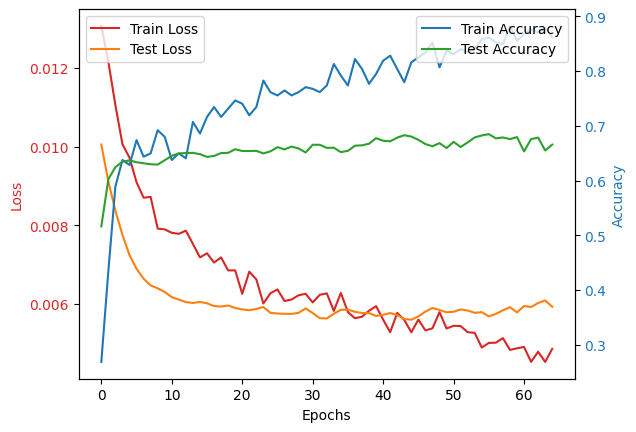

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.0049925662240597425, average accuracy 87.31163323990828
Test: Average loss 0.005876353626288559, average accuracy 68.65246050590737


In [18]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, Transfer1LSTMModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/200 AVG Training Loss:0.01031 AVG Test Loss:0.00893 AVG Training Acc 36.25 % AVG Test Acc 46.27 %
Epoch:20/200 AVG Training Loss:0.00913 AVG Test Loss:0.00811 AVG Training Acc 50.76 % AVG Test Acc 51.09 %
Epoch:30/200 AVG Training Loss:0.00772 AVG Test Loss:0.00757 AVG Training Acc 62.54 % AVG Test Acc 53.73 %
Epoch:40/200 AVG Training Loss:0.00684 AVG Test Loss:0.00740 AVG Training Acc 69.18 % AVG Test Acc 55.98 %
Epoch:50/200 AVG Training Loss:0.00555 AVG Test Loss:0.00731 AVG Training Acc 76.44 % AVG Test Acc 58.39 %
Epoch:60/200 AVG Training Loss:0.00418 AVG Test Loss:0.00757 AVG Training Acc 85.80 % AVG Test Acc 59.02 %
Early stopping triggered after epoch 65
Fold 2
Epoch:10/200 AVG Training Loss:0.01016 AVG Test Loss:0.00886 AVG Training Acc 41.69 % AVG Test Acc 43.59 %
Epoch:20/200 AVG Training Loss:0.00900 AVG Test Loss:0.00803 AVG Training Acc 52.27 % AVG Test Acc 52.43 %
Epoch:30/200 AVG Training Loss:0.00766 AVG Test Loss:0.00755 AVG Training Acc 65.56 % AVG 

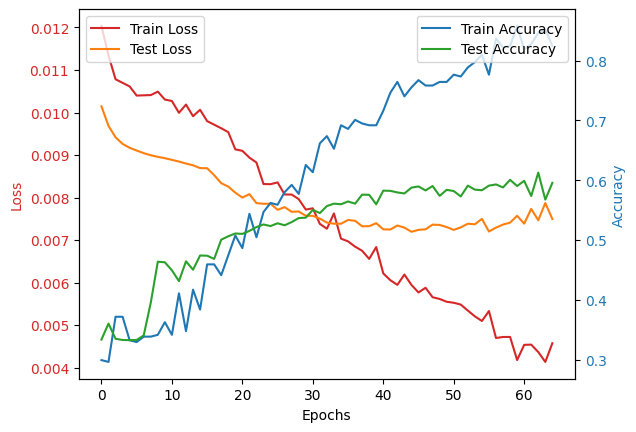

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.0036974240742176064, average accuracy 89.20995158883267
Test: Average loss 0.007244774851569753, average accuracy 63.23761304568064


In [19]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs=200
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, Transfer1LSTMModel, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

In [16]:
# transfer_def = TransferDef()
# transfer_def.return_request = [4]

# from torch.utils.tensorboard import SummaryWriter

# model = TransferModel(buffer, transfer_def)

# # Initialize the summary writer
# writer = SummaryWriter()

# # Create dummy input that corresponds to the network's input shape
# input_tensor = torch.rand(128, 1000, 12)

# # Add the model graph to TensorBoard
# writer.add_graph(model, input_tensor)
# writer.close()


# test_forwards(model, data_12lead, labelmap, device)

NameError: name 'TransferDef' is not defined

In [17]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20


for base_decay in [0.00001 * 2 ** i for i in range(10)]:
    trainparams.base_decay = base_decay

    history = train_kfold_transfer_model(dataset_12lead, trainparams, Transfer1LSTMModel, buffer=buffer, test=False, verbose=False)

    # plot_tt_graph(history, idx=0)

    print(f'\n\n\n##### decay rate {base_decay}')
    display_results(history, trainparams=trainparams)




##### decay rate 1e-05
Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.003515718478222798, average accuracy 89.8434826920977
Test: Average loss 0.005989823706583004, average accuracy 69.8279068641048



##### decay rate 2e-05
Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.003814008234803219, average accuracy 89.84466567175045
Test: Average loss 0.006042977111640661, average accuracy 68.90027919600699



##### decay rate 4e-05
Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.003914609225044797, average accuracy 91.29181378080297
Test: Average loss 0.006075163668153682, average accuracy 69.48633406067954



##### decay rate 8e-05
Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.00421939900609562, average accuracy 90.41686382994213
Test: Average loss 0.006153810057798845, average accuracy 69.10787334533593



##### decay rate 0.00016
Overall results

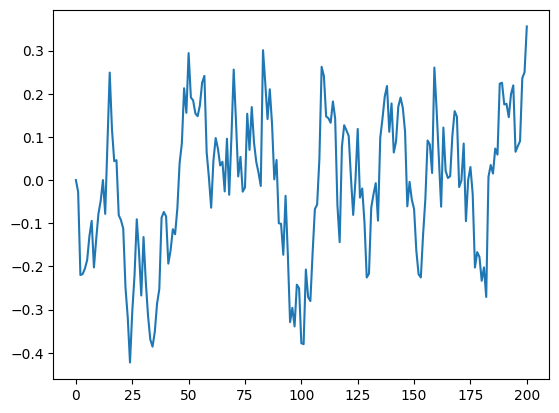

In [17]:
RandomAugment(device)

In [19]:
control_dataset = WindowDataset(data_1lead, labelmap, device=device, trim_samples=1000)

8528it [00:01, 7248.86it/s]


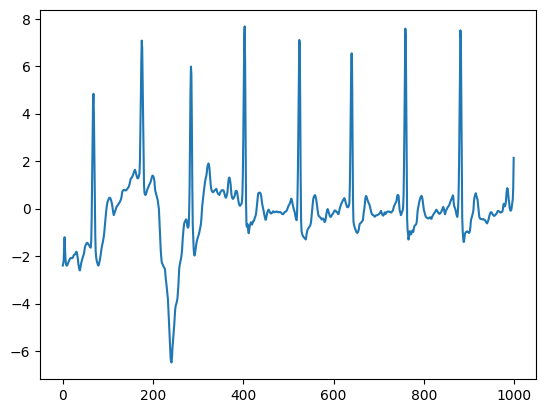

In [25]:
waveform, label, rpeaks = control_dataset.__getitem__(0, return_rpeaks=True)
plt.plot(waveform.cpu())

In [137]:
augment_dataset = AugmentDataset(data_1lead, labelmap, device=device, trim_samples=1000)

8528it [00:01, 7163.48it/s]


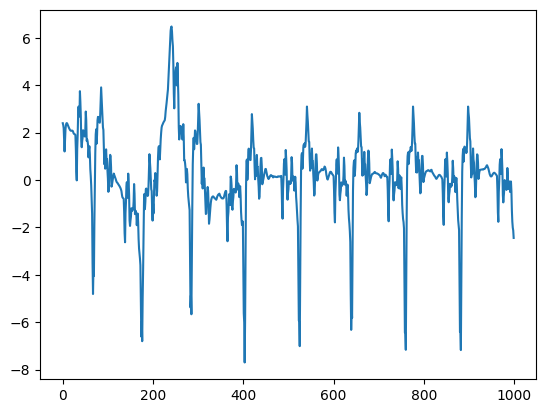

In [144]:
waveform, label = augment_dataset.__getitem__(0)
plt.plot(waveform[:,4].cpu())

In [36]:
augment_dataset.__getitem__(0)[0].shape

torch.Size([1000, 12])

8528it [00:01, 7242.58it/s]


Fold 1
0
1
2
3
4
5
6
7
8
9
Epoch:10/100 AVG Training Loss:0.00685 AVG Test Loss:0.00594 AVG Training Acc 70.42 % AVG Test Acc 69.97 %
10
11
12
13
14
15
16
17
18
19
Epoch:20/100 AVG Training Loss:0.00645 AVG Test Loss:0.00578 AVG Training Acc 74.18 % AVG Test Acc 70.67 %
20
21
22
23
24
25
26
27
28
29
Epoch:30/100 AVG Training Loss:0.00602 AVG Test Loss:0.00585 AVG Training Acc 77.23 % AVG Test Acc 70.44 %
30
31
32
33
34
35
36
37
38
39
Epoch:40/100 AVG Training Loss:0.00571 AVG Test Loss:0.00578 AVG Training Acc 79.46 % AVG Test Acc 70.65 %
40
41
42
43
44
Early stopping triggered after epoch 45


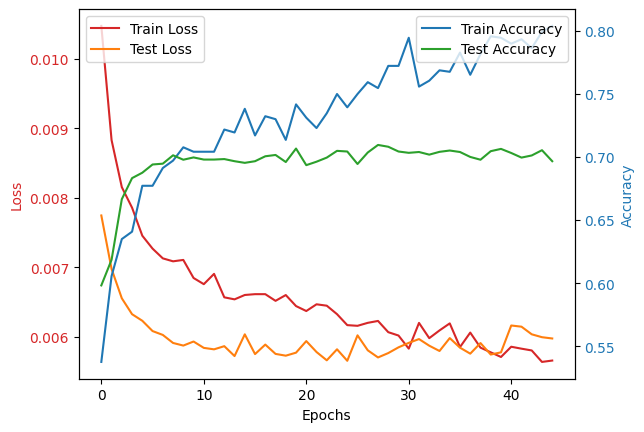

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.0056621919215565, average accuracy 80.39906103286386
Test: Average loss 0.005979426612824186, average accuracy 70.96143824908808


In [37]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

augment_dataset = AugmentDataset(data_1lead, labelmap, device=device, trim_samples=1000)

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(augment_dataset, trainparams, Transfer1LSTMModel, buffer=buffer, test=True)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)